In [1]:
# Imports
import praw
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import re

In [2]:
np.random.seed(42)

# Table of Contents
1. [EDA](#eda)
2. [Model 1: Random Forest with RandomizedSearchCV](#model-1-random-forest-with-randomizedsearchcv)
3. [Model 2: Support Vector Machine with RandomizedSearchCV](#model-2-support-vector-machine-with-randomizedsearchcv)
4. [Model 3: Random Forest Without Stop Words](#model-3-random-forest-without-stop-words)

## EDA

Load in from the .env file

In [3]:
# Commented out as I am not collecting any more data

# # Load the environment variables from the .env file
# load_dotenv('Reddit Info.env')

# # Access the env files
# secret_key = os.getenv('secret_key')
# reddit_username = os.getenv('reddit_username')
# reddit_password = os.getenv('reddit_password')
# personal_use_key = os.getenv('personal_use_key')

Access reddit 

In [4]:
# Commented out as I am not collecting any more data

# reddit = praw.Reddit(
#     client_id= personal_use_key,
#     client_secret = secret_key,
#     password= reddit_password,
#     user_agent = "Class Project 3 (by u/glittering-pack-9564)",
#     username = reddit_username,
# )

# # checking to make sure it worked
# # should be false
# print(reddit.read_only)

Choose two subreddits and get posts

In [5]:
# Commented out as I am not collecting any more data

# # Choosing subreddit and getting posts
# subreddit_wallstreetbets = reddit.subreddit('wallstreetbets')
# subreddit_stocks = reddit.subreddit('stocks')
# posts_wallstreetbets = subreddit_wallstreetbets.new(limit=100)
# posts_stocks = subreddit_stocks.new(limit=100)


# data_wallstreetbets = []
# for post in posts_wallstreetbets:
#     data_wallstreetbets.append([post.created_utc, post.title, post.selftext, post.subreddit])
    
# data_stocks = []
# for post in posts_stocks:
#     data_stocks.append([post.created_utc, post.title, post.selftext, post.subreddit])

# # Turn into a dataframe
# wallstreetbets = pd.DataFrame(data_wallstreetbets, columns = ['created_utc', 'title', 'self_text', 'subreddit'])
# stocks = pd.DataFrame(data_stocks, columns = ['created_utc', 'title', 'self_text', 'subreddit'])

# # Drop any duplicate posts
# wallstreetbets = wallstreetbets.drop_duplicates(subset=['created_utc', 'title'])
# stocks = stocks.drop_duplicates(subset=['created_utc', 'title'])


Append posts to a .csv file in order to save and get back a dataframe from the .csv file

In [6]:
# Commented out as I am not collecting any more data

# # saves data to csv and appends new data
# wallstreetbets.to_csv('./data/Wallstreetbets data.csv',
#                      mode = 'a', # appending to the .csv file
#                      index = False,
#                      header = False) # taking off the headers for easier appending

# stocks.to_csv('./data/stocks data.csv',
#                      mode = 'a',
#                      index = False,
#                      header = False)

# gets back all the data with the new posts
wallstreetbets = pd.read_csv('./data/Wallstreetbets data.csv',names=['created_utc', 'title', 'self_text', 'subreddit'])
stocks = pd.read_csv('./data/Stocks data.csv',names = ['created_utc', 'title', 'self_text', 'subreddit'])

In [7]:
wallstreetbets.shape

(1100, 4)

In [8]:
wallstreetbets.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,Bear Market due to bad NVIDIA Earning?,Reasoning:\n\n1. Due to the rising yields the ...,wallstreetbets
1,1.731948e+09,Doing the inverse from now on,How to make a lose-lose situation. Exhibit A\n...,wallstreetbets
2,1.731947e+09,Wen moon?,NaN,wallstreetbets
3,1.731947e+09,Me forgetting NVDA earnings is this week and q...,I think I’m done.,wallstreetbets
4,1.731946e+09,TIL Peloton is not up to 200% in a year and va...,Every now and then I check my little trading a...,wallstreetbets


In [9]:
stocks.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,EQIX and DLR - are they benefitting at all fro...,I had been wondering if datacenter REIT's such...,stocks
1,1.731947e+09,"What are some high risk, high reward stocks I ...","I'm still in high school, so I don't pay any e...",stocks
2,1.731947e+09,Creating Stop Loss on Webull?,I'm trying to create my first stop Loss on Web...,stocks
3,1.731945e+09,S&P 500 Rebalancing Trade,The S&P 500 index rebalancing occurs 4x/year w...,stocks
4,1.731945e+09,BioNTech Analysis and Questions,Let me first talk about the BioNTech's Q3 2024...,stocks


In [10]:
stocks.shape

(1100, 4)

In [11]:
wallstreetbets.isnull().sum()

created_utc      0
title            0
self_text      327
subreddit        0
dtype: int64

In [12]:
stocks.isnull().sum()

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

Get rid of any null values for both DataFrames

In [13]:
# I know that the subreddit wallstreetbets sometimes will post images or videos with no text and only a title so I will replace NaNs with just a word
# I do not think the stocks subreddit is allowed to just post a picture due to the rules of the subreddit but it cannot hurt.
wallstreetbets['self_text'] = wallstreetbets['self_text'].replace({np.nan:'Image'})
stocks['self_text'] = stocks['self_text'].replace({np.nan:'Image'})

Concatenate both dataframes

In [14]:
df_model_1 = pd.concat([wallstreetbets, stocks],
                      ignore_index = True) # the index does not matter 
df_model_1['subreddit'] = df_model_1['subreddit'].map({'wallstreetbets': 0,
                                         'stocks': 1})

In [15]:
df_model_1.head()

,created_utc,title,self_text,subreddit
0,1.731948e+09,Bear Market due to bad NVIDIA Earning?,Reasoning:\n\n1. Due to the rising yields the ...,0
1,1.731948e+09,Doing the inverse from now on,How to make a lose-lose situation. Exhibit A\n...,0
2,1.731947e+09,Wen moon?,Image,0
3,1.731947e+09,Me forgetting NVDA earnings is this week and q...,I think I’m done.,0
4,1.731946e+09,TIL Peloton is not up to 200% in a year and va...,Every now and then I check my little trading a...,0


## Model 1: Random Forest with RandomizedSearchCV

In [16]:
# commenting out because the model was saved 

X = df_model_1[['title','self_text']]
y = df_model_1['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# pipe_1 = Pipeline([
#     ('cvec',CountVectorizer()),
#     ('rf', RandomForestClassifier())
# ])

# pipe_params_1 = {
#     'cvec__max_features': np.arange(400,551,10), # Max number of frequently occuring words to include
#     'cvec__min_df': np.arange(1,11),  # Lowest amount of times a word can appear to be included
#     'cvec__max_df': [0.8, 0.95], # exclude words that appear in 80% or more of the posts
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)], # n-grams uni, bi, tri
#     'rf__n_estimators': np.arange(50,250),  # Number of trees in the forest
#     'rf__max_depth': np.arange(1,31),  # Maximum depth of the tree
#     'rf__min_samples_split': [2,3,4],  # Minimum number of samples to split a node
# }

# rs_1 = RandomizedSearchCV(
#     pipe_1, 
#     pipe_params_1,
#     n_iter = 50,
#     cv=5,
#     n_jobs = -1 # use all available cores
# )


# Best Parameters: {'rf__n_estimators': 113, 'rf__min_samples_split': 3, 'rf__max_depth': 30, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 6, 'cvec__max_features': 410, 'cvec__max_df': 0.8}
# Best Cross-Validation Score: 0.9848484848484848
# Training Accuracy: 0.9981818181818182
# Test Accuracy: 0.9818181818181818

In [17]:
# %%time
# rs_1.fit(X_train['title'] + " " + X_train['self_text'], y_train)


# # save the model
# # Credit to chatgpt for showing me this
# joblib.dump(rs_1,'./Models/Random Forest Model 1.pkl')

# Reload model
# Changed name of model to rf_1 from rs_1
rf_1 = joblib.load('./Models/Random Forest Model 1.pkl')

In [18]:
print('Best Parameters:', rf_1.best_params_)
print('Best Cross-Validation Score:', rf_1.best_score_)
print('Training Accuracy:', rf_1.score(X_train['title'] + " " + X_train['self_text'],y_train))
print('Test Accuracy:', rf_1.score(X_test['title'] + " " + X_test['self_text'],y_test))

Best Parameters: {'rf__n_estimators': 113, 'rf__min_samples_split': 3, 'rf__max_depth': 30, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 6, 'cvec__max_features': 410, 'cvec__max_df': 0.8}
Best Cross-Validation Score: 0.9848484848484848
Training Accuracy: 0.9981818181818182
Test Accuracy: 0.9818181818181818


## Model 2: Support Vector Machine with RandomizedSearchCV

In [19]:
# commenting out because the model was saved

# X = df_model_1[['title','self_text']]
# y = df_model_1['subreddit']
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# pipe_2 = Pipeline([
#     ('cvec',CountVectorizer()),
#     ('svm', SVC(kernel = 'rbf'))
# ])

# pipe_params_2 = {
#     'cvec__max_features': [500,700,1000], # Max number of frequently occuring words to include
#     'cvec__min_df': [5,15,20,30],  # Lowest amount of times a word can appear to be included
#     'cvec__max_df': [0.8, 0.95], # exclude words that appear in 80% or more of the posts
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)], # n-grams uni, bi, tr,
#     'svm__C': np.linspace(0.001,2,10),  # Regularization parameter
# }

# rs_2 = RandomizedSearchCV(
#     pipe_2, 
#     pipe_params_2,
#     n_iter = 500,
#     cv=5,
#     n_jobs = -1 # use all available cores
# )


# Best Parameters: {'svm__C': 2.0, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 15, 'cvec__max_features': 1000, 'cvec__max_df': 0.95}
# Best Cross-Validation Score: 0.9745454545454544
# Training Accuracy: 0.990909090909091
# Test Accuracy: 0.9654545454545455

In [20]:
# %%time
# rs_2.fit(X_train['title'] + " " + X_train['self_text'], y_train)

# save the model
# joblib.dump(rs_2,'./Models/Support Vector Machine Model.pkl')

# Reload model
svm_1 = joblib.load('./Models/Support Vector Machine Model.pkl')

In [21]:
print('Best Parameters:', svm_1.best_params_)
print('Best Cross-Validation Score:', svm_1.best_score_)
print('Training Accuracy:', svm_1.score(X_train['title'] + " " + X_train['self_text'],y_train))
print('Test Accuracy:', svm_1.score(X_test['title'] + " " + X_test['self_text'],y_test))

Best Parameters: {'svm__C': 2.0, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 15, 'cvec__max_features': 1000, 'cvec__max_df': 0.95}
Best Cross-Validation Score: 0.9745454545454544
Training Accuracy: 0.9866666666666667
Test Accuracy: 0.9781818181818182


## Model 3: Random Forest Without Stop Words

This model was used for the presentation

In [22]:
# Model was saved so commenting out

X = df_model_1[['title','self_text']]
y = df_model_1['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y)

# pipe_3 = Pipeline([
#     ('cvec',CountVectorizer(stop_words = 'english')),
#     ('rf', RandomForestClassifier())
# ])

# pipe_params_3 = {
#     'cvec__max_features': np.arange(400,551,10), # Max number of frequently occuring words to include
#     'cvec__min_df': np.arange(1,11),  # Lowest amount of times a word can appear to be included
#     'cvec__max_df': [0.8, 0.95], # exclude words that appear in 80% or more of the posts
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)], # n-grams uni, bi, tri
#     'rf__n_estimators': np.arange(50,250),  # Number of trees in the forest
#     'rf__max_depth': np.arange(1,31),  # Maximum depth of the tree
#     'rf__min_samples_split': [2,3,4],  # Minimum number of samples to split a node
# }

# rs_3 = RandomizedSearchCV(
#     pipe_3, 
#     pipe_params_3,
#     n_iter = 100,
#     cv=5,
#     n_jobs = -1 # use all available cores
# )


# Best Parameters: {'rf__n_estimators': 238, 'rf__min_samples_split': 4, 'rf__max_depth': 29, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 5, 'cvec__max_features': 490, 'cvec__max_df': 0.8}
# Best Cross-Validation Score: 0.9818181818181818
# Training Accuracy: 0.9963636363636363
# Test Accuracy: 0.9872727272727273

In [23]:
# %%time
# rs_3.fit(X_train['title'] + " " + X_train['self_text'], y_train)

Save the model and changed the variable for the model to rf_2 from rs_3

In [24]:
# # save the model
# joblib.dump(rs_3,'./Models/Random Forest Model Without Stop Words.pkl')

# Reload model
rf_2 = joblib.load('./Models/Random Forest Model Without Stop Words.pkl')

In [25]:
print('Best Parameters:', rf_2.best_params_)
print('Best Cross-Validation Score:', rf_2.best_score_)
print('Training Accuracy:', rf_2.score(X_train['title'] + " " + X_train['self_text'],y_train))
print('Test Accuracy:', rf_2.score(X_test['title'] + " " + X_test['self_text'],y_test))

Best Parameters: {'rf__n_estimators': 238, 'rf__min_samples_split': 4, 'rf__max_depth': 29, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 5, 'cvec__max_features': 490, 'cvec__max_df': 0.8}
Best Cross-Validation Score: 0.9818181818181818
Training Accuracy: 0.9987878787878788
Test Accuracy: 0.98


Generate a top features of the model graph 

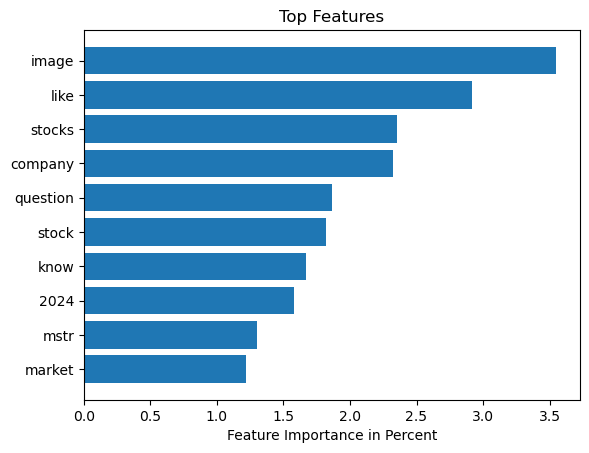

In [26]:
# Get the trained vectorizer from pipeline
vectorizer = rf_2.best_estimator_.named_steps['cvec']

# Extract feature names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the Random Forest classifier from the pipeline
model = rf_2.best_estimator_.named_steps['rf']

# Get feature importances from the Random Forest model
importances = model.feature_importances_

df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

df_sorted = df.sort_values(by='Importance', ascending = False)

plt.barh(df_sorted['Feature'][:10], df_sorted['Importance'][:10] * 100)
plt.gca().invert_yaxis() # From Stack Overflow
plt.xlabel("Feature Importance in Percent")
plt.title("Top Features");
plt.savefig('./Images/Top Features')

Generate top 10 words from each subreddit graphs

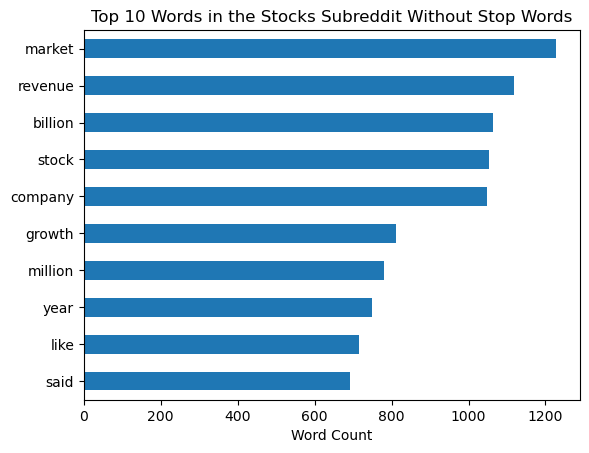

In [27]:
# Function to remove URLs and other puncuation 
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)
    # Remove punctuation and special characters (except for spaces and letters/numbers)
    text = re.sub(r'[^\w\s]', '', text)  # This removes everything except alphanumeric characters and spaces
    return text

# Apply the clean_text removal function to the text columns
stocks_text_cleaned = stocks['title'].str.lower() + " " + stocks['self_text'].str.lower()
stocks_text_cleaned = stocks_text_cleaned.apply(clean_text)

# Now apply CountVectorizer on the cleaned text
cvec_stocks = CountVectorizer(stop_words='english')
cvec_stocks_matrix = cvec_stocks.fit_transform(stocks_text_cleaned)

# Sum the word counts for each word across all documents
word_counts = cvec_stocks_matrix.sum(axis=0).A1  # Convert to a 1D array using .A1

# Create a DataFrame with word counts
stocks_word_counts_df = pd.DataFrame(
    list(zip(cvec_stocks.get_feature_names_out(), word_counts)),
    columns=['word', 'count']
)

# Sort by count in descending order and plot the top 10 words
ax = stocks_word_counts_df.sort_values(by='count', ascending=False).head(10).plot(kind='barh', x='word')
plt.xlabel('Word Count')
plt.title('Top 10 Words in the Stocks Subreddit Without Stop Words')
ax.legend().set_visible(False)  # Remove the legend
ax.set_ylabel('')  # Remove the y-axis label
plt.gca().invert_yaxis(); # Invert y-axis to show the most frequent word at the top
plt.savefig('./Images/Top 10 Words Stocks')

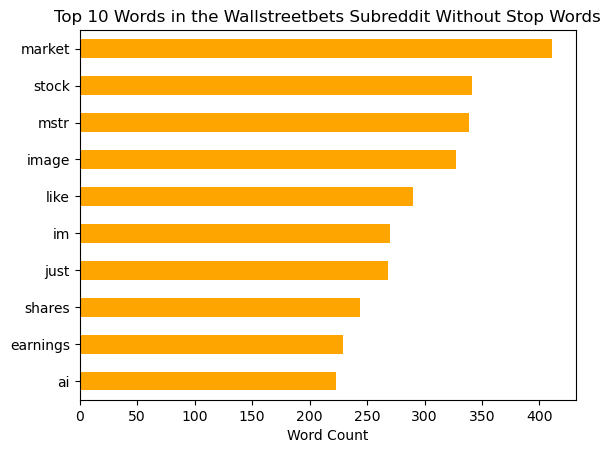

In [28]:
# Apply the clean_text removal function to the text columns
wallstreetbets_text_cleaned = wallstreetbets['title'].str.lower() + " " + wallstreetbets['self_text'].str.lower()
wallstreetbets_text_cleaned = wallstreetbets_text_cleaned.apply(clean_text)

# Now apply CountVectorizer on the cleaned text
cvec_wallstreetbets = CountVectorizer(stop_words='english')
cvec_wallstreetbets_matrix = cvec_wallstreetbets.fit_transform(wallstreetbets_text_cleaned)

# Sum the word counts for each word across all documents
word_counts_wallstreetbets = cvec_wallstreetbets_matrix.sum(axis=0).A1  # Convert to a 1D array using .A1

# Create a DataFrame with word counts
wallstreetbets_word_counts_df = pd.DataFrame(
    list(zip(cvec_wallstreetbets.get_feature_names_out(), word_counts_wallstreetbets)),
    columns=['word', 'count']
)

# Sort by count in descending order and plot the top 10 words
ax = wallstreetbets_word_counts_df.sort_values(by='count', ascending=False).head(10).plot(kind='barh', x='word',color = 'orange')
plt.xlabel('Word Count')
plt.title('Top 10 Words in the Wallstreetbets Subreddit Without Stop Words')
ax.legend().set_visible(False)  # Remove the legend
ax.set_ylabel('')  # Remove the y-axis label
plt.gca().invert_yaxis();  # Invert y-axis to show the most frequent word at the top
plt.savefig('./Images/Top 10 Words Wallstreetbets')

Check random sample of predictions

In [29]:
# Select a few random sample indices from the test set
sample = X_test.sample(10, random_state=42).index

# Extract sample data for actual values and features
sample_X = X_test.loc[sample]
sample_y_actual = y_test.loc[sample]

# Create a DataFrame to display the results
sample_results = pd.DataFrame({
    'Text': sample_X['title'] + " " + sample_X['self_text'],  # Combine relevant columns if necessary
    'Actual Label': sample_y_actual
})
pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width
sample_results.head(1)

# too much text cannot use in a presentation

,Text,Actual Label
1358,"NICE Ltd., an undervalued AI stock that is positioned well whether or not generative AI even works There may be literally only one stock that has not been swept up by AI hysteria, despite pivoting their business model to adapt to the prospect of generative AI - NICE Ltd.\n\nNICE Ltd., headquartered in Ra'anana, Israel, provides advanced cloud-based software for customer experience (CX) and financial crime prevention. NICE specializes in AI-driven platforms like CXone, which supports customer engagement through AI-based customer routing, automated interactions, and real-time analytics. Their Enlighten AI suite enhances contact center operations by helping agents offer more responsive, personalized service. They also offer solutions for digital evidence management and fraud detection, serving sectors like public safety, law enforcement, and financial compliance.\n\nNICE has been quietly rising ahead of their **earnings call tomorrow**, currently trading around $200. However, it is still WELL off of their high of $250. Their stock price the last several months has seen a sharp decline due to their longtime CEO, Barak Eilam, announcing his departure that will take place at the end of 2024. NICE, in my opinion, has taken an unfair beating for this news. Their replacement, Scott Russell, is an interesting hire due to his experience in the APAC market at a company the size of SAP and his international experience.\n\nNICE has not penetrated the European and APAC market well at all, and this could be an incredible opportunity to grow revenue in those markets with his appointment. They are already well entrenched in some of the largest F500 companies in the Americas. It's about time they start looking abroad.\n\nTo speak on the tech itself, and whether or not generative AI will work in this industry, that itself represents an interesting scenario for NICE. In my opinion, whether or not AI works, NICE is positioned well. Their last earnings call, analysts asked Barak specifically about whether or not their generative AI systems are being used by their customers. He mentioned their proprietary ""co-pilot"", internally-faced AI used by customer service agents is being heavily utilized, and bookings is up 100% YOY for the technology, but that there is definitely still some hesitancy to roll out a generative AI customer service platform to the end consumer. This is fine, in my opinion, because if conceptually it doesn't work, NICE's technology is needed, and will serve the market as it has for years. If generative AI is the solution this industry will need, then they are even better positioned for that against the market with their technology. \n\nSome of the risks that I've heard. One is valid the other isn't. It is an Israeli based company, so there are going to be risks endemic there that are inevitable, which is valid.\n\nI also hear about how large companies like Microsoft and Amazon will enter this market and take away market share. This is really unlikely. Microsoft, for example, tried to do a CRM tool and it is truly dogshit and has close to zero market share. And CX software requires much more domain expertise than doing a CRM tool, which they failed spectacularly at. \n\nI'll spare you the valuation work but...Anyway, stock is fairly priced close to $300, and is currently trading at $200. I got in at $165 earlier this year, but this is still a great opportunity.\n\n\n\n",1


Make a classification report

In [30]:
# Generate predictions on the test set
y_pred = rf_2.predict(X_test['title'] + " " + X_test['self_text'])
# Classification report
report = classification_report(y_test,y_pred)
# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       275
           1       0.97      0.99      0.98       275

    accuracy                           0.98       550
   macro avg       0.98      0.98      0.98       550
weighted avg       0.98      0.98      0.98       550



Make a confusion matrix

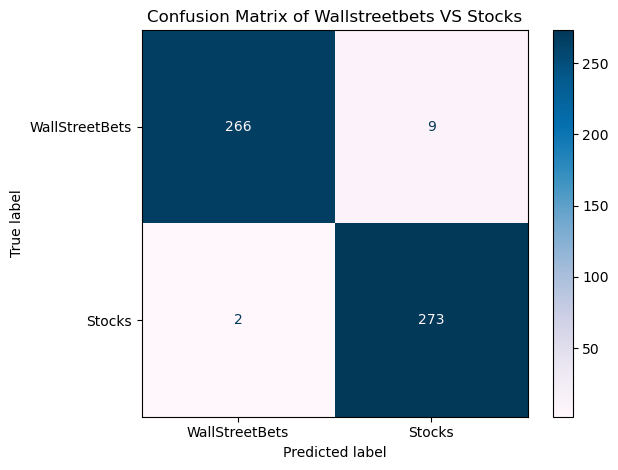

In [31]:
# Confusion matrix
labels = ["WallStreetBets", "Stocks"]
ConfusionMatrixDisplay.from_estimator(rf_2,
                                      X_test['title'] + " " + X_test['self_text'],
                                      y_test,
                                      display_labels=labels,
                                     cmap = 'PuBu')
plt.title('Confusion Matrix of Wallstreetbets VS Stocks')
plt.tight_layout();
plt.savefig('./Images/Confusion Matrix')